![image source: https://www.artbreeder.com/image/4740f9c3d7ceac2112e54cd77b5c](images/2025-02-10-diffusion-model-mnist-part1.jpeg)

## Introduction  

Ever been amazed by AI-generated images? Let's demystify the magic behind them! Have you ever wondered how a machine can generate something coherent from pure randomness? Take a look at the image below. On the left, you see a jumble of random pixels — digital noise. On the right, a crisp, recognizable MNIST digit emerges. This transformation from noise to structure is powered by **Diffusion Models**, a revolutionary approach in deep learning.  

::: {layout-ncol=2}
![](images/2025-02-10-diffusion-model-mnist-part1/noise_image.png){.lightbox}

![](images/2025-02-10-diffusion-model-mnist-part1/mnist-digit.png){.lightbox}
:::

But how does this noise-to-image process actually work? Imagine an old analog TV with no signal. The screen fills with static — random noise. Diffusion models learn to **reverse this process**, starting from pure noise and gradually refining it into a meaningful image. Think of it as a sophisticated un-blurring process. If you had an extremely blurry image of a digit, a diffusion model would learn to iteratively "de-blur" it, bringing the digit into sharp focus — step by step — until the final image is clear.  

MNIST digits provide the perfect playground for exploring this concept. Their simplicity allows us to focus on the **core mechanics of diffusion** without the added complexity of full-color, high-resolution images. In this post, we'll take a hands-on approach, building our own **MNIST digit generator from scratch** to truly understand how diffusion models work.  

### What to Expect  

We'll break down diffusion models into **four key stages**, each progressively refining our approach:  

1. **Baseline Model:** We'll start with a simple **Convolutional UNet** trained to directly generate MNIST digits. This serves as our foundation before diving into diffusion.  
2. **Architecture Improvements:** Next, we'll enhance our UNet using a more advanced design from the **diffusers library**, seeing firsthand how architectural tweaks improve results.  
3. **Introducing Diffusion:** Now comes the core idea — rather than predicting full images, we train our model to predict **noise**, the crucial step that enables real diffusion.  
4. **Full Diffusion Process:** Finally, we'll integrate a **noise scheduler**, allowing our model to iteratively denoise images, unlocking the true power of diffusion models.  

By the end of this journey, you’ll not only understand how diffusion models generate images but also **build one yourself**! Whether you're a deep-learning enthusiast or an AI researcher, this hands-on approach will give you both **intuitive understanding** and **practical experience** in one of the most exciting areas of machine learning today.  

Ready to dive in? Let’s get started!

### Credits

This post is inspired by the [Hugging Face Diffusion Course](https://huggingface.co/learn/diffusion-course/en/unit1/3)

### Environment Details

Run the following cell to install the required packages.

* This notebook can be run with [Google Colab](https://colab.research.google.com/) T4 GPU runtime.
* I have also tested this notebook with AWS SageMaker Jupyter Notebook running on instance "ml.g5.xlarge" and image "SageMaker Distribution 2.3.0"

In [1]:
%%capture
!pip install datasets[vision]
!pip install diffusers
!pip install watermark
!pip install torchinfo
!pip install matplotlib

[WaterMark](https://github.com/rasbt/watermark) is an IPython magic extension for printing date and time stamps, version numbers, and hardware information. Let's load this extension and print the environment details.

In [2]:
%load_ext watermark

In [3]:
%watermark -v -m -p torch,torchvision,datasets,diffusers,matplotlib,watermark,torchinfo

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 7.34.0

torch      : 2.5.1+cu124
torchvision: 0.20.1+cu124
datasets   : 3.2.0
diffusers  : 0.32.2
matplotlib : 3.10.0
watermark  : 2.5.0
torchinfo  : 1.8.0

Compiler    : GCC 11.4.0
OS          : Linux
Release     : 6.1.85+
Machine     : x86_64
Processor   : x86_64
CPU cores   : 2
Architecture: 64bit



## Data Preparation for MNIST: Simple Digits, Simple Setup  

Before training our diffusion model to generate MNIST digits, we first need to **prepare the dataset properly**. Data preparation is a critical step in any machine learning project, especially for image-based models. Think of it like setting up an artist’s workspace — before painting, an artist ensures they have the right *canvas* and *paints*. Similarly, our model needs **well-structured, consistently formatted, and properly scaled data** to learn effectively and generate high-quality results.  

In this section, we’ll go through the **key steps** required to get our MNIST digits ready for diffusion modeling.  

### Loading the MNIST Dataset  

Loading the MNIST dataset is incredibly easy, thanks to the [Hugging Face `datasets` library](https://huggingface.co/docs/datasets/en/index). With just one line of code, we can download and load the dataset:

In [4]:
from datasets import load_dataset
dataset = load_dataset("mnist")
print(dataset)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


Here’s what happens under the hood:  

- The `load_dataset("mnist")` function from the `datasets` library **automatically downloads** the MNIST dataset (if not already cached) and prepares it for use.  
- Running `print(dataset)` reveals that it is stored as a `DatasetDict` with two splits: `'train'` and `'test'`. Each split contains a `Dataset` object with `'image'` and `'label'` features.  
- Although the dataset includes labels, **we will not use them** for our unconditional image generation task.  
- The images are in **grayscale** with pixel values ranging from **0 to 255**.

Let's display a sample image from the training dataset.

In [5]:
from IPython.display import display

# Extract a sample image from the dataset
sample_image = dataset["train"]["image"][0]

# Print details about the image
print("Data Type:", type(sample_image))  # Shows the type of object
print("Image Size:", sample_image.size)  # Displays dimensions of the image

# Display the image
# sample_image.show()
display(sample_image)

Data Type: <class 'PIL.PngImagePlugin.PngImageFile'>
Image Size: (28, 28)


From the last cell output, you can see the loaded images are object of [Python Image Library (PIL)](https://pillow.readthedocs.io/en/stable/index.html) and are very tiny in their actual size. Let's enlarge the sample image and view it up close.

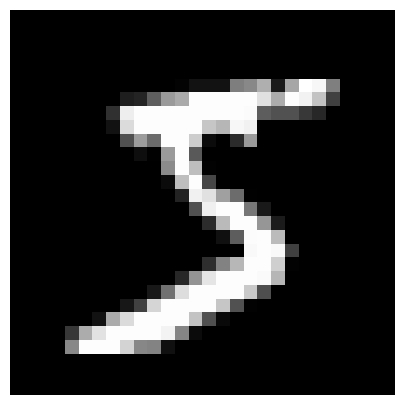

In [6]:
import matplotlib.pyplot as plt

# Display the image with a larger size
plt.figure(figsize=(5, 5))  # Adjust the figure size as needed
plt.imshow(sample_image, cmap="gray")  # Use "gray" colormap for MNIST images
plt.axis("off")  # Hide axis for better visibility
plt.show()

Each image is made up of small square pixels, with values ranging from 0 (black) to 255 (white). The grayscale intensity of each pixel determines how bright or dark it appears. By displaying these pixel values, we can understand how the model sees the image.

In [7]:
import numpy as np

# Convert image to NumPy array
image_array = np.array(sample_image)

# Print the pixel values in a structured format
for row in image_array:
    print(" ".join(f"{pixel:3}" for pixel in row))  # Align values properly


  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136 175  26 166 255 247 127   0   0   0   0
  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253 225 172 253 242 195  64   0   0   0   0
  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251  93  82  82  56  39   0   0   0   0   0
  0   0   0   0   0   0   0  18 219 253 253 253 253 253 198 182 247 241   0   0   0   0   0   0   0   0 

### Preprocessing for MNIST Images

Once the MNIST dataset is loaded, the next crucial step is **preprocessing** the images. Raw MNIST images, which are grayscale and 28×28 in size, need to be formatted appropriately for deep learning models. Proper preprocessing helps standardize the input data, making it easier for the model to learn effectively.  

In this pipeline, we will use `torchvision.transforms.Compose` to apply a series of transformations:  

- **Resizing**: Ensures all images are a consistent size (e.g., 32×32).  
- **Tensor Conversion**: Converts images to PyTorch tensors and scales pixel values to \[0,1\].

Below is the code for our preprocessing pipeline:

In [8]:
import torch
from torchvision import transforms

image_size = 32  # Define the target image size (e.g., 32x32)

preprocess = transforms.Compose([
    transforms.Resize((image_size, image_size)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert images to tensors & scale pixel values to [0, 1]
])

Each function in `transforms.Compose()` plays a crucial role in preparing the images:  

- **`transforms.Resize((image_size, image_size))`**  
  - Resizes images to **32×32 pixels** (or any chosen `image_size`).  
  - Ensures a consistent input size for our UNet model.  
- **`transforms.ToTensor()`**  
  - Converts images from **PIL format** to **PyTorch tensors**.  
  - Scales pixel values from **[0, 255]** to **[0, 1]** for compatibility with deep learning models.

#### Applying the Transformations to the Dataset

With our preprocessing pipeline defined, we now need to **apply it to the dataset**. Instead of modifying the dataset in advance, we’ll use **on-the-fly transformations** — ensuring preprocessing is applied only when data is accessed, keeping memory usage efficient.  

To achieve this, we define a transformation function and set it for our dataset:

In [9]:
# Define the transform function
def transform(examples):
    examples = [preprocess(image) for image in examples["image"]]
    return {"images": examples}

# Apply the transform to the dataset
dataset.set_transform(transform)

In this code:

- **The `transform` function**  
  - Receives batches of examples from the dataset.  
  - Applies the `preprocess` pipeline (resizing, tensor conversion) to the `'image'` feature using list comprehension.  
  - Returns a dictionary with the transformed images under the key `'images'`.  
- **`dataset.set_transform(transform)`**  
  - Associates the `transform` function with the dataset.  
  - Ensures that preprocessing is **dynamically applied** whenever data is accessed, rather than modifying and storing a preprocessed copy.  

#### Creating the DataLoader  

With our dataset preprocessed, the next step is to create a **DataLoader**. PyTorch's `DataLoader` is an essential utility that efficiently handles data loading during training. It performs key tasks such as:  

- **Batching**: Groups images into batches for efficient processing, especially when using a GPU.  
- **Shuffling**: Randomizes the order of samples to prevent the model from memorizing patterns based on dataset order.  
- **Efficient Loading**: Streams data dynamically, preventing memory bottlenecks.  

Shuffling is particularly important as it enhances the model’s **generalization ability**, ensuring it learns meaningful patterns rather than sequence-based biases.  

Here’s how to create a **DataLoader** for the MNIST training set:

In [10]:
import torch
from torch.utils.data import DataLoader

batch_size = 8 # Define batch size (adjust as needed based on GPU memory)
# Using a small batch size for easier visual validation of images.
# When training, we will use a larger batch size for efficiency.

train_dataloader = DataLoader(dataset["train"], batch_size=batch_size, shuffle=True)

In this code snippet:

- **`batch_size = 8`**: Defines the number of images in each batch. Larger batch sizes can speed up training but require more memory. Adjust as needed based on your hardware.  
- **`dataset["train"]`**: Specifies the training split of the MNIST dataset.  
- **`shuffle=True`**: Ensures that data is randomly shuffled at the beginning of each training epoch, preventing the model from learning sequence-based biases.  

With `train_dataloader` set up, we are now fully equipped to feed **batches of preprocessed MNIST images** into our diffusion model during training.

#### Visualizing a Batch of Preprocessed Images

Before training a model, it’s important to verify that our data preprocessing pipeline is functioning as expected. One effective way to do this is by visualizing a batch of preprocessed images. This allows us to check whether key transformations — such as resizing and tensor conversion — have been applied correctly.  

We can use `matplotlib` along with `torchvision.utils.make_grid` to display a grid of images from our `train_dataloader`. This quick visual inspection helps confirm that the images are correctly formatted and ready for model training.  

Below is a simple implementation to visualize a batch:

Input shape: torch.Size([8, 1, 32, 32])


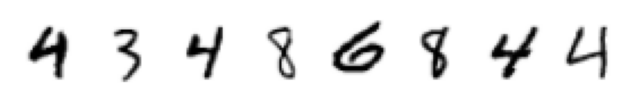

In [11]:
import torchvision

# Get a batch of images from the dataloader
data_iter = iter(train_dataloader)
batch = next(data_iter)  # Get the first batch
imgs = batch["images"]  # Get images from the batch

print("Input shape:", imgs.shape)

# Visualize the batch
plt.figure(figsize=(8, 8))
plt.axis("off")
plt.imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys")
plt.show()

Our images have been transformed from pixel-based representations to tensors, making them more suitable for training. Now, let's visualize how a single image appears after these transformations.

Pixel values after preprocessing:
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.2 0.4 0.5 0.3 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.5 0.9 0.9 0.6 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.3 0.8 0.9 0.8 0.5 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.6 0.9 0.9 0.5 0.1 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.1 0.8 0.

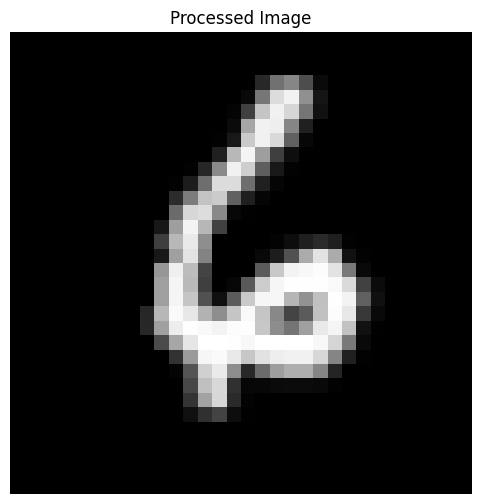

In [12]:
# Take the first image from the batch
image_tensor = next(iter(train_dataloader))["images"][0]

# Convert tensor to NumPy array
image_array = image_tensor.numpy()

# Convert from (C, H, W) to (H, W) since it's grayscale
image_array = image_array.squeeze(0)

# Print pixel values
print("Pixel values after preprocessing:")
for row in image_array:
    print(" ".join(f"{pixel:.1f}" for pixel in row))

# Display the image for reference
plt.figure(figsize=(6,6))
plt.imshow(image_array, cmap="gray", interpolation="nearest")
plt.title("Processed Image")
plt.axis("off")
plt.show()

## Understanding the Noise Corruption Function  

### Introducing the `corrupt` Function  

In diffusion models, we need a systematic way to introduce noise into clean images. This controlled noise addition is crucial for simulating the forward diffusion process, where an image gradually transforms from a structured state to pure noise. To achieve this, we use a helper function called `corrupt`.  

The `corrupt` function takes a batch of clean images and progressively degrades them by blending in random noise at varying levels, determined by an `amount` parameter. This function plays a fundamental role in diffusion models, enabling a structured transition from the original image to noise. While our initial implementation will use a simplified version, understanding its mechanics is essential, as more advanced models will build upon this process.  

Now, let's examine its implementation:

In [13]:
# Definition of the noise corruption function
def corrupt(x, noise, amount):
    amount = amount.view(-1, 1, 1, 1)  # make sure it's broadcastable
    return (
        x * (1 - amount) + noise * amount
    )  # equivalent to x.lerp(noise, amount)

The function `corrupt(x, noise, amount)` takes three input arguments:  

- **`x`**: A batch of clean images, represented as a PyTorch tensor with shape `(batch_size, 1, image_size, image_size)`.  
- **`noise`**: A tensor of random values, matching the shape of `x`, representing the noise to be added.  
- **`amount`**: A tensor of shape `(batch_size,)`, specifying the level of noise corruption for each image in the batch.  

Since `amount` is a 1D tensor, it must be reshaped to match the dimensions of `x` for proper broadcasting during element-wise operations. This is achieved with:  

```
amount = amount.view(-1, 1, 1, 1)
```  

This transformation ensures that `amount` is applied consistently across all pixels and channels of each image.  

The core logic of noise corruption is in the return statement:  

```
return x * (1 - amount) + noise * amount
```  

This expression performs a smooth interpolation between the original image `x` and the noise `noise`, controlled by `amount`:  

- `(1 - amount)`: As `amount` increases from `0` to `1`, this value decreases from `1` to `0`.  
- `x * (1 - amount)`: The **clean image is scaled down** based on `(1 - amount)`.
  - If `amount` is near `0`, the image remains mostly intact.
  - If `amount` is near `1`, its contribution diminishes significantly.  
- `noise * amount`: The **noise is scaled up** in proportion to `amount`.
  - At `amount = 0`, no noise is added
  - At `amount = 1`, the image is entirely replaced by noise.
- The sum of these terms creates a seamless blend, where the noise level increases progressively with `amount`.  

By structuring the noise corruption process this way, we ensure that images degrade in a controlled and predictable manner — an essential property for training diffusion models.

To better understand how the `corrupt` function modifies images, we will apply it to a batch of MNIST digits with varying levels of noise and visualize the results. The code below retrieves a batch of images from `train_dataloader`, generates a range of noise levels, applies the `corrupt` function, and then displays both the clean and noisy images.

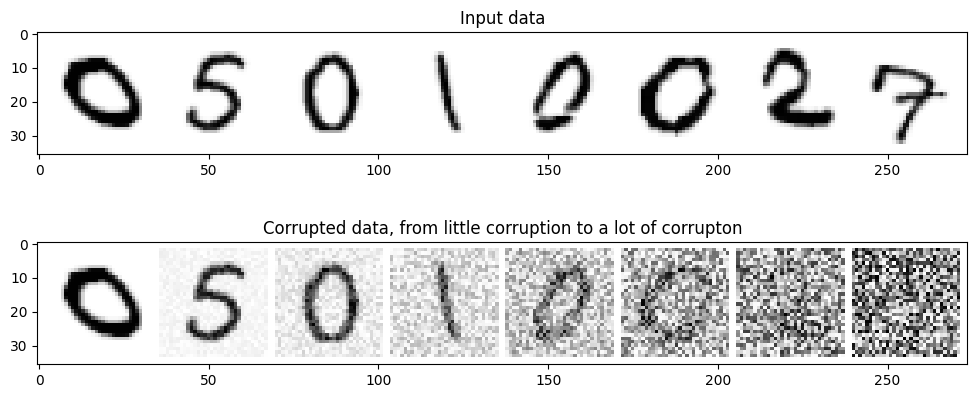

In [14]:
# --- Visualizing the effect of the corrupt function ---
# Get a batch of images from the training dataloader
batch = next(iter(train_dataloader))
imgs = batch["images"]

# Prepare noise and noise amounts for visualization
amount = torch.linspace(0, 1, imgs.shape[0]) # Noise amounts from 0 to 1
noise = torch.rand_like(imgs)                # Random noise tensor
noised_x = corrupt(imgs, noise, amount)      # Apply corrupt function

# --- Plotting the input and corrupted images ---
fig, axs = plt.subplots(2, 1, figsize=(12, 5)) # Create figure and axes for plotting

# Plotting the original input data
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(imgs)[0], cmap="Greys") # Display original images in top row

# Plotting the corrupted version
axs[1].set_title("Corrupted data, from little corruption to a lot of corrupton")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys") # Display corrupted images in bottom row

plt.show() # Show the plot

Running this code generates a visualization consisting of two rows of MNIST digits:  

1. **Top row (Input data)** – This row displays the original, clean MNIST digits from `train_dataloader`. These digits are sharp and clearly recognizable. This serves as our reference point before noise is applied.  
2. **Bottom row (Corrupted data, from little corruption to a lot of corruption)** – This row shows the same digits after being processed by the `corrupt` function. Observing from left to right, we can see an increasing level of noise corruption.  

- **Leftmost images**: The noise level is minimal, so these images closely resemble the originals in the top row.  
- **Gradual progression**: Moving toward the right, noise becomes more prominent, making the digits less distinct.  
- **Rightmost images**: The noise level is at its maximum, significantly obscuring the original digit. In extreme cases, the digit may become unrecognizable.  

This visualization clearly illustrates the behavior of the `corrupt` function. By adjusting the `amount` parameter, we can precisely control the degree of noise added to an image — ranging from slight perturbations to near-complete corruption. This capability will be crucial in our exploration of diffusion models, where controlled noise application is fundamental to the learning process.

## Model 1: Simple Convolutional UNet for Direct Image Prediction

### Why Use UNets for Diffusion?

Before building our first model, the **Simple Convolutional UNet**, let’s first understand why this architecture is essential for diffusion models.

In the context of diffusion models, "diffusion" refers to a process inspired by natural phenomena — like how a drop of ink disperses in water until it is evenly distributed. In machine learning, this concept is mimicked by gradually adding noise to an image until it turns into pure random noise, similar to TV static. This is known as the **forward diffusion process**. The goal, however, is to reverse this process — step by step removing the noise to recover a meaningful image. This is the **reverse diffusion process**, and the neural network responsible for this denoising task is often a **UNet**.

UNets are widely used for this purpose because they excel at image-to-image tasks, particularly **restoring details from noisy images**. Their **U-shaped architecture** consists of two key parts:

1. **The downsampling path (encoder):** This progressively reduces the image size while extracting important features.
2. **The upsampling path (decoder):** This reconstructs the image while preserving fine details.

A crucial component of UNets is **skip connections**, which transfer detailed features from the encoder directly to corresponding layers in the decoder. These connections help the network retain high-frequency information, such as edges and textures, which are often lost during downsampling.

![Basic UNet Diagram](images/2025-02-10-diffusion-model-mnist-part1/basic-unet.png){.lightbox}

While other architectures could be used, UNets have consistently proven to be highly effective at reversing the diffusion process and generating high-quality images.

Interestingly, UNets were not originally developed for diffusion models or image generation. They were first introduced for **medical image segmentation**, where precise localization of structures (such as tumors in MRI scans) is critical. Their success in medical imaging, which requires balancing **contextual understanding** and **fine-detail preservation**, makes them an excellent choice for denoising in diffusion models.

In our first model, **Model 1**, we will use a simplified UNet for **direct image prediction** — a stepping stone toward more advanced diffusion models.

### Our Direct Image Prediction Approach

To ease into the concepts behind diffusion models, **Model 1** takes a simplified approach: **direct image prediction**. Instead of fully implementing a diffusion model that gradually removes noise in multiple steps, we will train a **Convolutional UNet** to denoise an image in **a single forward pass**.

It’s important to note that this is **not** a true diffusion model. Unlike traditional diffusion models, which iteratively refine an image by predicting noise at each step, this UNet directly predicts the clean version of a noisy MNIST digit in one go.

Why start with this approach?

1. **It simplifies the learning process.** By focusing solely on the UNet's architecture and training, we can avoid the complexities of diffusion schedulers and iterative sampling.
2. **It establishes a useful baseline.** This basic denoising UNet allows us to compare performance as we transition to more sophisticated, iterative diffusion models.

::: {.callout-tip collapse="true" title="Are There U-Net Architectures Without Convolutional Layers?"}

When discussing U-Net architectures, we often assume they are convolution-based. But are there U-Net variants that don’t use convolutional layers at all?

Yes, there are. Below are some alternatives that replace convolutions with different computational approaches.

#### 1. Fourier Neural Operator U-Net (FNO-U-Net)
This model replaces the usual convolutional layers with **Fourier Transforms**. Instead of learning patterns using small local filters (like in a CNN), it transforms the image into the **frequency domain**, where patterns can be processed more efficiently.  

- **How it works:**  
  - Converts the image into a set of wave-like components using the **Fourier Transform**.  
  - Performs operations in this transformed space.  
  - Converts the data back to an image after processing.  

- **Why it’s useful:**  
  - Can capture both fine details and large-scale structures at the same time.  
  - Works well for tasks like weather prediction and fluid dynamics, where patterns extend across large areas.  

#### 2. Siren U-Net  
Instead of using convolutions, this model relies on **Sinusoidal Representation Networks (SIREN)**, which use sine functions as activation functions. This allows the network to smoothly model continuous signals.  

- **How it works:**  
  - Instead of filters scanning small regions, the network represents the image as a continuous mathematical function.  
  - Uses sine waves to reconstruct and modify the image.  

- **Why it’s useful:**  
  - Great for tasks involving **highly detailed textures** or **continuous signals**, such as 3D modeling or implicit shape representations.  
  - Can generate images at any resolution without pixelation.  

#### 3. MLP-Mixer U-Net  
This model replaces convolutions with **fully connected layers** that process information across the entire image. Instead of scanning with filters, it mixes and reshapes the image data in two main steps:  

- **How it works:**  
  - **First step:** Processes information across different image locations (spatial mixing).  
  - **Second step:** Processes information across different color or feature channels (channel mixing).  
  - This ensures that both **local and global information** is captured.  

- **Why it’s useful:**  
  - Works well when the relationships between different parts of an image are more important than local details.  
  - Good for medical imaging, where entire structures matter more than tiny textures.

:::

### Building a Simple Convolutional UNet

Now, let's construct a **minimal yet functional UNet** that serves as the core of our direct image prediction approach.

#### Network Architecture
Our **Convolutional UNet**, implemented as the `BasicUNet` class, follows the standard U-shape design, consisting of:

- **A contracting path (encoder)**: This reduces spatial dimensions while capturing important features through a series of convolutional layers and downsampling operations.
- **An expanding path (decoder)**: This restores the original image size using convolutional layers and upsampling, reconstructing the denoised image.
- **Skip connections**: These directly pass feature information from the encoder to the decoder, preserving fine details during the upsampling process.

Here's the PyTorch code for our BasicUNet class, implementing the simple convolutional UNet architecture we just described:

In [15]:
from torch import nn


class BasicUNet(nn.Module):
    """A minimal UNet implementation."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = nn.ModuleList(
            [
                nn.Conv2d(64, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, out_channels, kernel_size=5, padding=2),
            ]
        )

        # Use the SiLU activation function, which has been shown to work well
        # due to different properties (smoothness, non-monotonicity, etc.).
        self.act = nn.SiLU()
        self.downscale = nn.MaxPool2d(2)
        self.upscale = nn.Upsample(scale_factor=2)

    def forward(self, x):
        h = []
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))
            if i < 2:  # For all but the third (final) down layer:
                h.append(x)  # Storing output for skip connection
                x = self.downscale(x)  # Downscale ready for the next layer

        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upscale
                x += h.pop()  # Fetching stored output (skip connection)
            x = self.act(l(x))

        return x

In [16]:
from torchinfo import summary

# initialize the model
model = BasicUNet()

# print model info
print(model)
summary(model)

BasicUNet(
  (down_layers): ModuleList(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (up_layers): ModuleList(
    (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (2): Conv2d(32, 1, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  )
  (act): SiLU()
  (downscale): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (upscale): Upsample(scale_factor=2.0, mode='nearest')
)


Layer (type:depth-idx)                   Param #
BasicUNet                                --
├─ModuleList: 1-1                        --
│    └─Conv2d: 2-1                       832
│    └─Conv2d: 2-2                       51,264
│    └─Conv2d: 2-3                       102,464
├─ModuleList: 1-2                        --
│    └─Conv2d: 2-4                       102,464
│    └─Conv2d: 2-5                       51,232
│    └─Conv2d: 2-6                       801
├─SiLU: 1-3                              --
├─MaxPool2d: 1-4                         --
├─Upsample: 1-5                          --
Total params: 309,057
Trainable params: 309,057
Non-trainable params: 0

#### Explaining the Simple Conv UNet Code

Let's break down the `BasicUNet` code step-by-step to understand its inner workings.

We begin by defining our UNet as a Python class in PyTorch: `class BasicUNet(nn.Module):`. This line creates a class named `BasicUNet` that inherits from `nn.Module`.  In PyTorch, `nn.Module` is the foundational building block for all neural networks. By inheriting from it, `BasicUNet` gains essential neural network capabilities.

Inside the `BasicUNet` class, we find the constructor: `def __init__(self, in_channels=1, out_channels=1):`. This special method, `__init__`, is executed when you create an instance of `BasicUNet`.  The parameters `in_channels=1` and `out_channels=1` are set here.  They specify that our UNet, by default, is designed to take **single-channel grayscale images (like MNIST digits) as input and produce single-channel grayscale images as output**.

##### **Encoder Path**

Next, we define the encoder or downsampling path: `self.down_layers = nn.ModuleList([...])`. `self.down_layers` is an `nn.ModuleList`, which acts like a Python list but specifically designed to hold PyTorch neural network layers. Within `self.down_layers`, we define a sequence of three `nn.Conv2d` (2D Convolutional) layers:

*   `nn.Conv2d(in_channels, 32, kernel_size=5, padding=2)`: This is the first convolutional layer of the encoder. `in_channels` (initially 1 for grayscale images) defines the number of input channels this layer expects. `32` is the number of output channels or feature maps that this layer will generate. `kernel_size=5` sets the size of the convolutional filter to 5x5 pixels, and `padding=2` adds padding around the input. This padding is used to maintain the spatial dimensions of the output feature map, ensuring it's the same size as the input.
*   `nn.Conv2d(32, 64, kernel_size=5, padding=2)`: The second convolutional layer takes `32` input channels (the output from the previous layer) and outputs `64` channels, further increasing the network's capacity to learn complex features.
*   `nn.Conv2d(64, 64, kernel_size=5, padding=2)`: The third convolutional layer takes `64` input channels and also outputs `64` channels. Notice how the number of feature channels increases in the encoder's initial layers. This is a common strategy in convolutional networks, allowing them to capture increasingly abstract and complex features as they go deeper.



::: {.callout-tip collapse="true" title="Why Conv2d and not Conv3d or Conv1d?"}

It’s important to understand that `nn.Conv2d` creates a **2D convolutional layer** specifically for two-dimensional data, such as images. In this context, **two dimensions refer to height and width**, not the number of color channels.  

All standard images—whether grayscale or RGB—are inherently **2D** because they have a height and width. However, the number of channels (e.g., **grayscale (1 channel), RGB (3 channels), or RGBA (4 channels)**) should not be confused with the concept of dimensionality.  

But why do we specifically call it a **2D convolutional layer**? The reason is that convolutional layers can operate on different types of data:  

- **Conv1d (`nn.Conv1d`)** is used for **1D data**, where the input has only one spatial dimension (e.g., **time series, audio signals, or text embeddings**).  
- **Conv2d (`nn.Conv2d`)** is for **2D data**, where the input has height and width (e.g., **grayscale or RGB images**).  
- **Conv3d (`nn.Conv3d`)** is for **3D data**, where the input has height, width, and depth (e.g., **CT scans, MRIs, or video frames**).  

For example:

- Conv1d is commonly used for speech processing (e.g., analyzing waveforms).  
- Conv2d is used for standard image processing (e.g., segmentation, classification).  
- Conv3d is useful for volumetric data (e.g., 3D medical scans, motion analysis in videos).  

:::

##### **Decoder Path**

Similarly, we define the decoder or upsampling path: `self.up_layers = nn.ModuleList([...])`.  `self.up_layers`, also an `nn.ModuleList`, holds the convolutional layers for the decoder. It contains three `nn.Conv2d` layers that, in terms of channel numbers, mirror the encoder in reverse. In the `forward` pass (explained later), these layers will be used in conjunction with upsampling to reconstruct the image:

*   `nn.Conv2d(64, 64, kernel_size=5, padding=2)`: The first convolutional layer in the decoder path.
*   `nn.Conv2d(64, 32, kernel_size=5, padding=2)`: The second convolutional layer, reducing the number of feature channels back to 32.
*   `nn.Conv2d(32, out_channels, kernel_size=5, padding=2)`: The final convolutional layer of the decoder. `out_channels` (which is 1 by default) ensures that the UNet outputs a single-channel grayscale image, consistent with the input.

##### **Activation Function**

`self.act = nn.SiLU()`: This line defines `self.act` as the SiLU (Sigmoid Linear Unit) activation function. Activation functions are crucial for introducing non-linearity into neural networks, enabling them to learn complex, non-linear relationships in the data. The SiLU activation **will be applied after each convolutional layer** in the forward pass.

##### **Down Sampling**

`self.downscale = nn.MaxPool2d(2)`: Here, `self.downscale` is defined as a `MaxPool2d` layer with a kernel size of 2. Max pooling is a downsampling technique. It reduces the spatial dimensions of feature maps by dividing the image into 2x2 blocks and keeping only the maximum value from each block. This effectively halves the height and width of the feature maps, reducing spatial size while retaining important features.

##### **Up Sampling**

`self.upscale = nn.Upsample(scale_factor=2)`: This defines `self.upscale` as an `Upsample` layer with a `scale_factor=2`. Upsampling is the inverse of downsampling; it increases the spatial size of feature maps. In this case, it doubles the height and width using nearest-neighbor interpolation by default, effectively reversing the spatial reduction done by max pooling in the encoder.

##### **Forward Pass**

Finally, the `forward(self, x):` method defines the forward pass of the network – how input data `x` flows through the layers to produce an output.

*   `h = []`: We initialize an empty list `h`. This list will serve as storage for intermediate feature maps from the encoder path. These **stored feature maps will be used later for skip connections** in the decoder.

*   The first `for i, l in enumerate(self.down_layers):` loop iterates through the encoder's convolutional layers (`self.down_layers`).
    *   `x = self.act(l(x))`: Inside the loop, for each convolutional layer `l`, we apply the layer to the current input `x` and then pass the result through the SiLU activation function (`self.act`). The output becomes the new `x`.
    *   `if i < 2: h.append(x); x = self.downscale(x)`: For the first two encoder layers (where `i` is 0 or 1, meaning not for the last encoder layer), we perform two key actions:
        *   `h.append(x)`: We store the output `x` of the activated convolutional layer into our skip connection list `h`. These stored feature maps from the encoder will be added to the decoder path later, enabling skip connections.
        *   `x = self.downscale(x)`: We apply the `MaxPool2d` downsampling (`self.downscale`) to reduce the spatial dimensions of `x`, preparing it to be processed by the next layer in the encoder path.  Downsampling is not performed after the final encoder layer in this architecture.

*   The second `for i, l in enumerate(self.up_layers):` loop iterates through the decoder's convolutional layers (`self.up_layers`).
    *   `if i > 0: x = self.upscale(x); x += h.pop()`: For all decoder layers except the first one (`i > 0`), we perform the following:
        *   `x = self.upscale(x)`: We upsample the feature map `x` using `self.upscale` to increase its spatial size, reversing the downsampling from the encoder.
        *   `x += h.pop()`: We implement the skip connection here. `h.pop()` retrieves the *last* stored feature map from our skip connection list `h`. We then add this retrieved feature map to the upsampled feature map `x`. This addition is the core of the skip connection, combining detailed features from the encoder with the upsampled features in the decoder to help preserve fine details during reconstruction.
    *   `x = self.act(l(x))`: After the optional upsampling and skip connection (for layers after the first in the decoder), we apply the current decoder layer `l` (a `Conv2d` layer) and then the SiLU activation function (`self.act`).

*   `return x`: Finally, the `forward` method returns the processed tensor `x`. This is the output of the UNet, representing the **predicted denoised MNIST digit** in our case.

### Training the Model

Now that we have defined the **BasicUNet** architecture, the next step is to train it. We will follow a standard **supervised learning approach** to train the UNet to predict clean MNIST digits from noisy inputs. This involves defining a **loss function**, selecting an **optimizer**, and implementing a **training loop**.

#### Loss Function: Mean Squared Error (MSE)
For this direct image prediction task, we use the **Mean Squared Error (MSE) loss**, implemented in PyTorch as `F.mse_loss` (from `torch.nn.functional`). MSE measures the average squared difference between the predicted image (output from the UNet) and the ground-truth clean image. By minimizing this loss, the model learns to generate outputs that closely match the original digits, ensuring pixel-wise accuracy.

#### Optimizer: Adam
We use the **Adam optimizer** (`torch.optim.Adam`) with a **learning rate of 1e-3 (0.001)**. Adam is a widely used optimizer that adapts the learning rate for each parameter, making training more stable and efficient. The learning rate determines how much the model’s weights are adjusted at each step—**too high** may lead to instability, while **too low** may slow down convergence.

#### Training Process
The model is trained for **5 epochs**, iterating through batches of MNIST images using `train_dataloader`. Within each epoch, the training loop performs the following steps:

1. **Load a batch of clean MNIST images** from `train_dataloader` and move them to the computing device (GPU or CPU).
2. **Generate noisy images** by adding **random noise** to the clean images. The noise level varies per image, controlled by a random `noise_amount` scalar.
3. **Feed the noisy images into the UNet**, which predicts the corresponding denoised images.
4. **Compute the MSE loss**, comparing the predicted images with the clean images.
5. **Perform backpropagation** to compute gradients, indicating how each model parameter should be adjusted.
6. **Update the model’s weights** using the Adam optimizer to minimize the loss.
7. **Store the loss value** for tracking training progress.

This process repeats for **5 epochs**, allowing the model to progressively improve its ability to denoise MNIST digits.

After training, we **plot the loss curve** to visualize how the MSE loss evolves over time.

In [17]:
from torch.nn import functional as F
from torch.optim import Adam
import matplotlib.pyplot as plt

# --- Check GPU Availability ---
device = "cuda" if torch.cuda.is_available() else "cpu" # Use GPU if available, else CPU
print("device: ", device)

# --- Hyperparameters and Setup ---
model = model.to(device)                             # Instantiate BasicUNet and move to device
optimizer = Adam(model.parameters(), lr=1e-3)             # Initialize Adam optimizer
losses = []                                                # Store loss values
num_epochs = 5                                             # Number of training epochs

batch_size = 128                                      # Larger batch size for training
train_dataloader = torch.utils.data.DataLoader(
    dataset["train"], batch_size=batch_size, shuffle=True
)

device:  cuda


In [18]:
# --- Training Loop ---
for epoch in range(num_epochs):
    for batch in train_dataloader:                         # Iterate over training batches
        clean_images = batch["images"].to(device)           # Load clean images

        # Sample noise to add to the images
        noise = torch.rand_like(clean_images).to(device)

        # Sample amount of noise to add to the images
        noise_amount = torch.randn(clean_images.shape[0]).to(device)

        # Add noise to the clean images according to the noise magnitude
        noisy_images = corrupt(clean_images, noise, noise_amount)

        predicted_images = model(noisy_images)             # Model predicts denoised images
        loss = F.mse_loss(predicted_images, clean_images)  # Compute MSE loss

        optimizer.zero_grad()                              # Clear previous gradients
        loss.backward()                                    # Backpropagate
        optimizer.step()                                   # Update model weights
        losses.append(loss.item())                         # Store loss

    # --- Print average loss per epoch ---
    avg_loss = sum(losses[-len(train_dataloader):]) / len(train_dataloader)
    print(f"Epoch {epoch+1}/{num_epochs} - Average Loss: {avg_loss:.4f}")

Epoch 1/5 - Average Loss: 0.0173
Epoch 2/5 - Average Loss: 0.0105
Epoch 3/5 - Average Loss: 0.0098
Epoch 4/5 - Average Loss: 0.0093
Epoch 5/5 - Average Loss: 0.0088


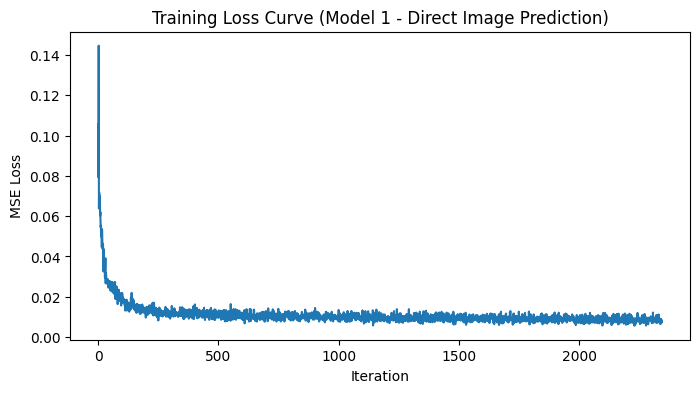

In [19]:
# --- Plot Loss Curve ---
plt.figure(figsize=(8, 4))
plt.plot(losses)
plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve (Model 1 - Direct Image Prediction)")
plt.show()

### Inference with Model

Now that **Model 1** is trained, we need to evaluate its ability to **denoise images it hasn’t encountered during training**. This process, known as **inference** (or sometimes **sampling** or **generation**), involves using the trained model to generate outputs on new data.  

For **Model 1**, inference is straightforward because it performs **direct image prediction** in a single forward pass. Given a noisy image as input, it directly outputs a **denoised** version.  

To assess Model 1’s denoising performance, we will use the **MNIST test dataset**. We’ll set up a `DataLoader` for the test set, similar to `train_dataloader`, but using `dataset["test"]` to load the test split. For each batch of test images, we will:  

1. **Load a batch of clean MNIST test images** from the `test_dataloader`.  
2. **Generate *new* noisy versions** of these test images.  
   - It’s crucial to use **fresh, randomly generated noise**—distinct from what was used during training—to properly evaluate the model’s ability to generalize to unseen noisy inputs.  
   - We will apply the same `corrupt` function (or inline noise corruption logic) used during training.  
3. **Feed the noisy test images into our trained `BasicUNet` model**.  
   - The model will produce its **predicted denoised images** in a **single forward pass**.  
   - This is **one-shot denoising**—no iterative refinement is involved.  
4. **Transfer the model’s denoised output to the CPU** and convert it to **NumPy arrays**.  
   - This step is necessary for visualization with `matplotlib`, which operates on NumPy arrays.  
5. **Visualize the results in a plot**, displaying:  
   - **Top row**: Original clean test images (ground truth).  
   - **Middle row**: Noisy test images (input to Model 1).  
   - **Bottom row**: Denoised images (Model 1 output).  

By analyzing this plot, we can visually assess how effectively **Model 1 denoises MNIST digits** using its **direct image prediction strategy** and how well it generalizes to **new noisy test data**.  

The PyTorch code for this inference and visualization process is provided in the subsequent code block.

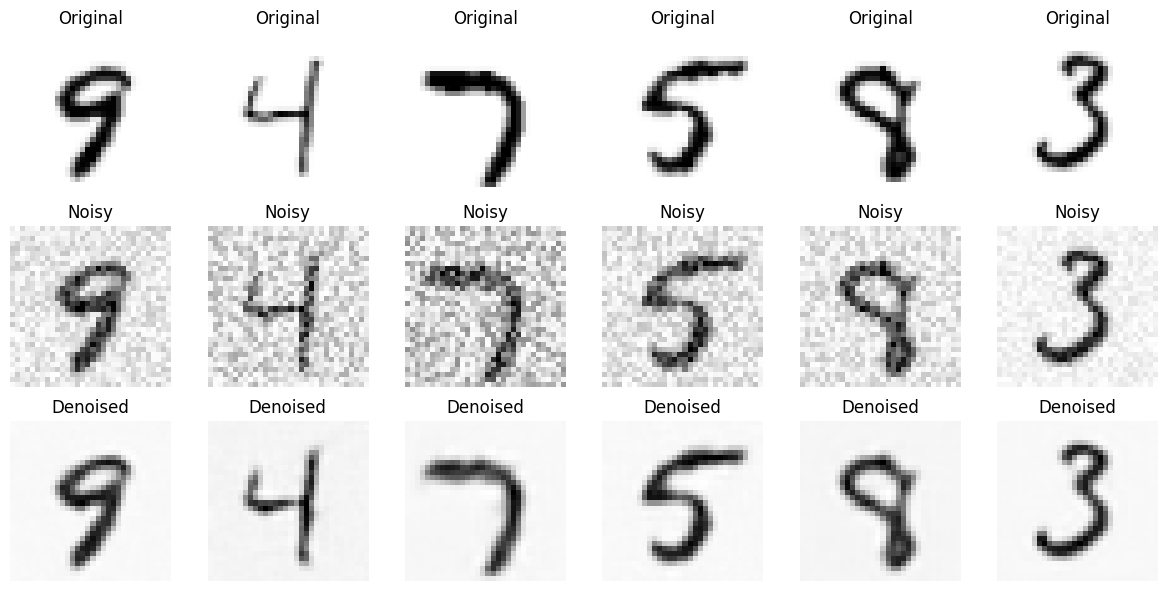

In [20]:
# --- Inference with Model 1 and Visualization ---
# --- Prepare test dataset and dataloader ---
test_dataset = load_dataset("mnist", split="test") # Load MNIST test split dataset
test_dataset.set_transform(transform)             # Apply preprocessing transform to test dataset
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=True) # Create DataLoader for test dataset

# --- Get a batch of test images ---
batch = next(iter(test_dataloader))
clean_images = batch["images"].to(device) # Load clean test images to the device

# --- Generate new random noise for inference ---
noise = torch.rand_like(clean_images).to(device) # Generate random noise tensor
noise_amount = torch.randn(clean_images.shape[0]).to(device) # Generate noise amount tensor
noisy_images = corrupt(clean_images, noise, noise_amount) # Create noisy test images by corruption

# --- Perform inference (get denoised images from Model 1) ---
model.eval()  # Set model to evaluation mode for inference
with torch.no_grad():  # Disable gradient calculation during inference
    denoised_images = model(noisy_images) # Get denoised images from model

# --- Move tensors to CPU and convert to NumPy for visualization ---
noisy_images_np = noisy_images.cpu().numpy() # Move noisy images to CPU and convert to NumPy
denoised_images_np = denoised_images.cpu().numpy() # Move denoised images to CPU and convert to NumPy
clean_images_np = clean_images.cpu().numpy() # Move clean images to CPU and convert to NumPy

# --- Plotting the results: Original, Noisy, Denoised ---
num_images = 6  # Set number of images to visualize
plt.figure(figsize=(12, 6)) # Initialize matplotlib figure for plotting

for i in range(num_images): # Loop through number of images to plot
    # --- Plot Original (Clean) Images ---
    plt.subplot(3, num_images, i + 1) # Create subplot for original images (top row)
    plt.imshow(clean_images_np[i].squeeze(), cmap='Greys') # Display original clean image
    plt.title("Original") # Set title for original image subplot
    plt.axis('off') # Hide axes for cleaner image display

    # --- Plot Noisy Images ---
    plt.subplot(3, num_images, i + num_images + 1) # Create subplot for noisy images (middle row)
    plt.imshow(noisy_images_np[i].squeeze(), cmap='Greys') # Display noisy image input
    plt.title("Noisy") # Set title for noisy image subplot
    plt.axis('off') # Hide axes

    # --- Plot Denoised Images ---
    plt.subplot(3, num_images, i + 2 * num_images + 1) # Create subplot for denoised images (bottom row)
    plt.imshow(denoised_images_np[i].squeeze(), cmap='Greys') # Display denoised output image
    plt.title("Denoised") # Set title for denoised image subplot
    plt.axis('off') # Hide axes

plt.tight_layout() # Adjust subplot layout for better spacing
plt.show() # Show the complete plot

### Results and Discussion

Running the inference code generates a plot displaying MNIST digits in three rows: **"Original," "Noisy," and "Denoised."** Let's first analyze these **initial one-shot denoising results** to evaluate the baseline performance of our **simple Model 1**.  

In the **"Denoised" row** (bottom row), you should notice that the digits are indeed **visibly denoised** compared to the **"Noisy" row** (middle row). The random noise has been reduced, and the digits appear **less blurred**, indicating that our basic **Convolutional UNet** has learned to remove some noise through its **direct image prediction strategy**.  

However, when comparing the **"Denoised" row** to the **"Original" row** (top row, showing clean digits), it becomes clear that the denoised digits are **not perfectly restored**. Some **residual blurriness** remains, and they lack the crispness and sharpness of the original images. Additionally, **minor noise artifacts** may still be visible. Despite these imperfections, the denoised outputs remain **recognizable as MNIST digits**, showing that the model has captured key visual features.  

#### Exploring Iterative Refinement  

To see if we can further improve upon these one-shot results, we experimented with a simple **iterative refinement approach**, even using our **direct prediction Model 1**. Instead of denoising in a single step, we start with **pure random noise** and iteratively refine it over **5 steps** using our trained model. The following code implements this process:  

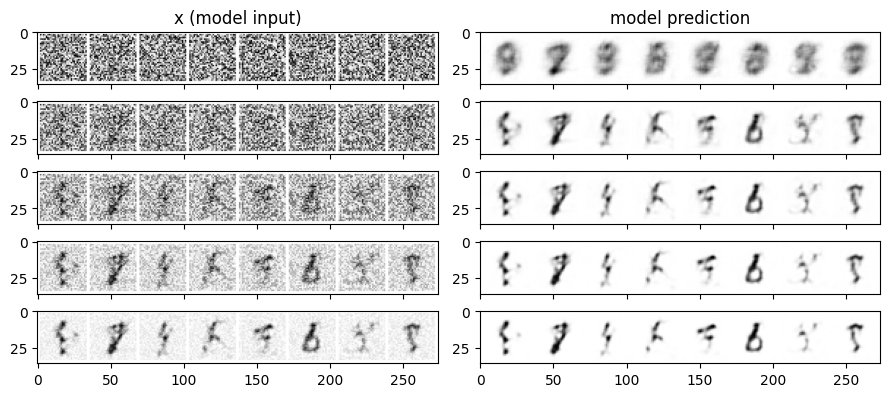

In [21]:
# --- Iterative Refinement Experiment (Model 1) ---
import torchvision
import matplotlib.pyplot as plt

n_steps = 5
x = torch.rand(8, 1, 32, 32).to(device) # Start from pure random noise
step_history = [x.detach().cpu()] # Store initial noise
pred_output_history = [] # Store model predictions at each step

for i in range(n_steps):
    with torch.no_grad():
        pred = model(x) # Get model's direct prediction
    pred_output_history.append(pred.detach().cpu()) # Store prediction
    mix_factor = 1 / (n_steps - i) # Increasing mix factor over steps
    x = x * (1 - mix_factor) + pred * mix_factor # Linear blend: refine x with prediction
    step_history.append(x.detach().cpu()) # Store refined x

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True) # Create 2-column plot
axs[0, 0].set_title("x (model input)") # Title for 'input' column
axs[0, 1].set_title("model prediction") # Title for 'prediction' column
for i in range(n_steps): # Loop to plot each step
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys") # Plot refined x
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys") # Plot prediction
plt.tight_layout()
plt.show()

Running this iterative refinement code generates a new plot with two columns:  

- **Left column ("x (model input)")** → Shows images at each step of the refinement process. Starting from **pure noise (top row),** you can observe how the images gradually become more digit-like over the **5 steps**.  
- **Right column ("model prediction")** → Displays the *direct predictions* of Model 1 at each step.  

Comparing the final **"x (model input)" image (bottom-left of this new plot)** to the **one-shot "Denoised" row** from the previous experiment, you may notice a **subtle but visible improvement** in image quality. The iteratively refined digits often appear **slightly sharper and more well-formed** compared to the one-shot denoised outputs.  

This suggests that even with a **direct prediction model**, a **basic iterative refinement approach** can enhance image quality. However, it's important to note that **this process is still a simplification**—it does not represent **true diffusion model sampling.** The model is still making **direct predictions**, and we are manually blending them to guide the image toward a cleaner state.  

## Key Takeaways & Next Steps

From both **one-shot denoising** and **iterative refinement**, we can conclude that even a **basic Convolutional UNet** trained for **direct image prediction** can perform some level of denoising on MNIST digits. However, to achieve **higher-quality, sharper, and more faithfully reconstructed digits**, we need to go beyond this basic approach.  

In the next section, we will **enhance our UNet architecture** using the `diffusers` library while still employing **direct image prediction**. This will allow us to examine how **architectural improvements** can further boost performance. Eventually, we will transition to **true noise prediction and scheduled denoising**, bringing us closer to the core principles of **diffusion models**.

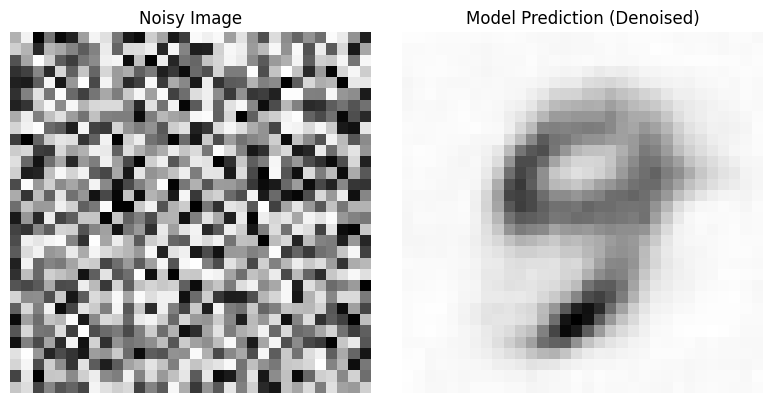

In [23]:
import torch
import matplotlib.pyplot as plt

# Generate a noisy image (random noise)
noise_image = torch.rand(1, 32, 32)  # Example: Single-channel (grayscale) 32x32 noise image

# Assume `model` is trained and available
with torch.no_grad():
    denoised_image = model(noise_image.unsqueeze(0).to(device))  # Add batch dimension & move to device
    denoised_image = denoised_image.squeeze(0).cpu().detach()  # Remove batch dim & move to CPU

# Plot both images side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

axs[0].imshow(noise_image.squeeze(), cmap="Greys")
axs[0].set_title("Noisy Image")
axs[0].axis("off")

axs[1].imshow(denoised_image.squeeze(), cmap="Greys")
axs[1].set_title("Model Prediction (Denoised)")
axs[1].axis("off")

plt.tight_layout()
plt.show()
